In [14]:
!pip install tensorflow-gpu numpy pandas matplotlib

In [15]:
!nvidia-smi

Thu Feb  4 06:19:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
# 초기 설정
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

EPOCHS = 10

In [17]:
# Resnet의 unit class
class ResidualUnit(tf.keras.Model):

    def __init__(self, filter_in, fileter_out, kernel_size):

        super(ResidualUnit, self).__init__()

        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(fileter_out, kernel_size, padding='same')

        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(fileter_out, kernel_size, padding='same')

        if filter_in == fileter_out:
            self.identity = lambda x: x

        else:
            self.identity = tf.keras.layers.Conv2D(fileter_out, (1,1), padding='same')


    def call(self, x, training=False, mask=None):
        h = self.bn1(x, training=training)
        h = tf.nn.relu(h)
        h = self.conv1(h)

        h = self.bn2(x, training=training)
        h = tf.nn.relu(h)
        h = self.conv2(h)
        return self.identity(x) + h
        

In [18]:
# Resnet Layer를 조정하는 곳
class ResnetLayer(tf.keras.Model):

    def __init__(self, filter_in, filters, kernel_size):
        super(ResnetLayer, self).__init__()
        self.sequence = list()

        for f_in, f_out in zip([filter_in] + list(filters), filters):
            self.sequence.append(ResidualUnit(f_in, f_out, kernel_size))

    def call(self, x, training=False, mask=None):
        for unit in self.sequence:
            x= unit(x, training=training)
        return x


In [19]:
## 모델 정의
class ResNet(tf.keras.Model):

    def __init__(self):
        super(ResNet, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(8, (3,3), padding='same', activation='relu')

        self.res1 = ResnetLayer(8, (16, 16), (3, 3))
        self.pool1 = tf.keras.layers.MaxPool2D((2,2))

        self.res2 = ResnetLayer(16, (32, 32), (3, 3))
        self.pool2 = tf.keras.layers.MaxPool2D((2,2))

        self.res3 = ResnetLayer(32, (64, 64), (3, 3))

        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense2 = tf.keras.layers.Dense(10, activation='softmax')


    def call(self, x, training=False, mask=None):

        x = self.conv1(x)

        x = self.res1(x, training=training)
        x = self.pool1(x)
        x = self.res2(x, training=training)
        x = self.pool2(x)
        x = self.res3(x, training=training)

        x = self.flatten(x)
        x = self.dense1(x)

        return self.dense2(x)


In [20]:
# 학습, 테스트 루프 정의하기
@tf.function
def train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy):

    with tf.GradientTape() as tape:

        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def test_step(model, images, labels, loss_object, test_loss, test_accuracy):

    predictions = model(images, training=False)

    t_lost = loss_object(labels, predictions)
    test_loss(t_lost)
    test_accuracy(labels, predictions)

In [21]:
# dataset
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train[..., tf.newaxis].astype(np.float32)
x_test = x_test[..., tf.newaxis].astype(np.float32)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [22]:
######### Model Test
model = ResNet()

# 손실함수 정의 및 최적화 기법 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# 평가지표 정의
train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")

test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")

In [23]:
# Model 실험 시작
epoch_list = list()
train_accuracy_list = list()
test_accuracy_list = list()

for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy)

    for test_images, test_labels in test_ds:
        test_step(model, test_images, test_labels, loss_object, test_loss, test_accuracy)

    epoch_list.append(epoch+1)
    train_accuracy_list.append(train_accuracy.result())
    test_accuracy_list.append(test_accuracy.result())
    
    template = "Epoch {}, Loss {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}"
    print(template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          test_loss.result(),
                          test_accuracy.result() * 100))

Epoch 1, Loss 0.13366854190826416, Accuracy: 96.40833282470703, Test Loss: 0.09382708370685577, Test Accuracy: 97.47000122070312
Epoch 2, Loss 0.10196486860513687, Accuracy: 97.26416778564453, Test Loss: 0.08074449002742767, Test Accuracy: 97.82500457763672
Epoch 3, Loss 0.08414334803819656, Accuracy: 97.73055267333984, Test Loss: 0.07173213362693787, Test Accuracy: 98.11333465576172
Epoch 4, Loss 0.07450366765260696, Accuracy: 97.98208618164062, Test Loss: 0.06555609405040741, Test Accuracy: 98.28500366210938
Epoch 5, Loss 0.06724043190479279, Accuracy: 98.17100524902344, Test Loss: 0.06200040504336357, Test Accuracy: 98.38800048828125
Epoch 6, Loss 0.06180455908179283, Accuracy: 98.31945037841797, Test Loss: 0.06010589376091957, Test Accuracy: 98.41500091552734
Epoch 7, Loss 0.05721912160515785, Accuracy: 98.45024108886719, Test Loss: 0.05834346264600754, Test Accuracy: 98.4671401977539
Epoch 8, Loss 0.05347076430916786, Accuracy: 98.55333709716797, Test Loss: 0.05610926076769829, Te

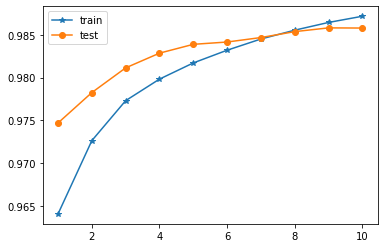

In [26]:
# 그래프 그리기
plt.plot(epoch_list, train_accuracy_list, marker='*')
plt.plot(epoch_list, test_accuracy_list, marker='o')
plt.legend(['train', 'test'])
plt.show()